# 1. Experimentos utilizando K-Means para Agrupamento

Neste notebook serão exploradas maneiras \~inteligentes\~ de segmentar os clientes com base nos atributos escolhidos anteriormente. K-Means será o algoritmo escolhido com base na sua fácil interpretabilidade e por ser um algoritmo conhecido para tarefas de agrupamento.

## Por que o "Inteligentes" está cercado por "\~"?

Como qualquer problema na computação e talvez na vida, devemos saber quais ferramentas usar para cada problema e entender como as ferramentas funcionam para evitar resultados indesejados, ou pior, resultados desejados, mas incorretos.

No caso deste processo de segmentação, uma grande importância relacionada aos resultados se darão por parte de como os dados serão preprocessados.

Por conta disso, serão exploradas algumas formas de preprocessamento e, com base nos resultados do modelo, serão definidas as segmentações finais para o uso na API desenvolvida.

### 1.1 Inicialização

In [73]:
import sklearn.cluster
import sklearn.decomposition
import sklearn.preprocessing

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

sns.set_theme()
sns.set_style("whitegrid")

# Random State
RS=42
COLORS = {0: 'blue',
         1: 'green',
         2: 'red'}

rfm = pd.read_csv('../data/processed/rfm.csv')
rfm.head()

,CustomerID,Recency,Frequency,Amount,Country
0,12346.0,326,0.0,0.00,United Kingdom
1,12347.0,40,182.0,4310.00,Iceland
2,12348.0,76,31.0,1797.24,Finland
3,12349.0,19,73.0,1757.55,Italy
4,12350.0,311,17.0,334.40,Norway


### 1.2 Geração AD-HOC de clusters

Primeiramente vamos explorar os resultados de uma segmentação realizada com K-Means utilizando Sklearn.

Para isso utilizaremos os atributos numéricos disponíveis na base gerada no notebook exploratório.

Neste exemplo, serão gerados apenas 3 clusters para realizar a segmentação de clientes. Espera-se que a segmentação seja feita de forma que seja fácil entender o motivo das diferenças entre os segmentos.

In [74]:
X = rfm[['Recency', 'Amount', 'Frequency']]
model = sklearn.cluster.KMeans(n_clusters=3, random_state=RS)
prediction = model.fit(X)
labels = prediction.labels_
colors = [COLORS[x] for x in labels]

A seguir são apresentados 2 gráficos para visualização da segmentação definida pelo K-Means.

A visualização 2D foi gerada a partir da aplicação do algoritmo de PCA, que realiza uma redução de dimensionalidade dos atributos mantendo apenas os atributos com informações mais relevantes.

In [90]:
# Vai ser usado algumas vezes para plotar
def plot2d(X, colors, title='Visualização 2D'):
    X_2d = sklearn.decomposition.PCA(2).fit_transform(X)
    x = X_2d[:, 0]
    y = X_2d[:, 1]
    plt.scatter(x, y, c=colors)
    plt.title("Visualização 2D")

def plot3d(x, y, z, colors, xlabel='Recência (maior é pior)', zlabel='Gastos (em milhares)', ylabel='Frequência', title='Dados Segmentados'):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(xs=x, ys=y, zs=z, c=colors)
    ax.set_xlabel(xlabel)
    ax.set_zlabel(zlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)

def run_kmeans(X):
    model = sklearn.cluster.KMeans(n_clusters=3, random_state=RS)
    prediction = model.fit(X)
    labels = prediction.labels_
    colors = [COLORS[x] for x in labels]
    return colors

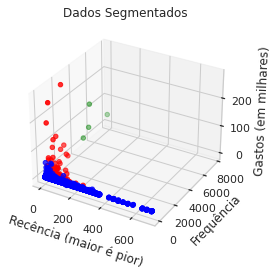

In [85]:
x = rfm['Recency']
y = rfm['Frequency']
z = rfm['Amount'] / 1000

plot3d(x, y, z, colors)

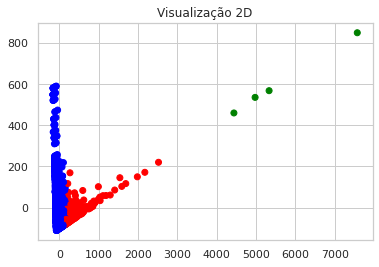

In [86]:
plot2d(X, colors)

Nota-se que no gráfico 3D, há uma segmentação onde o eixo de gastos parecer ter maior relevância. Apesar do maior espalhamento de exemplos no eixo de recência, o K-Means priorizou o eixo de gastos para segmentar os elementos.

Podemos ver esse comportamento no gráfico 2D, onde o PCA tendeu a deixar o eixo X como uma representação dos gastos e onde há visivelmente uma separação entre 3 grupos distintos de clientes.

A pergunta agora que vem é: Por qual motivo o K-Means resolveu cortar os clientes dessa forma? Aparentemente ele separou apenas entre clientes que gastam, de forma relativa, pouco, médio e muito.

O K-Means, de forma similar ao KNN, é um algoritmo baseado em distâncias e centróides. Isso quer dizer que a escala dos dados influencia grandemente na decisão da separação dos grupos. Como o eixo dos gastos tem grandeza muito maior que os outros eixos, as distâncias entre os pontos presentes nesse eixo são maiores e por conta disso, a decisão de cálculo do centróide do grupo que é baseado em distâncias, é fortemente afetado por esta diferença de grandeza.

É possível notar essa importância ao reduzir drasticamente a escala do eixo de gastos e perceber a nova segmentação de grupos.

<ipython-input-91-c2e68fd889f1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Amount'] = X['Amount']  / 100000


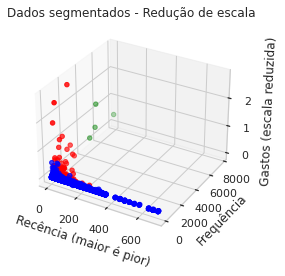

In [91]:
# Redução de escala
X = rfm[['Recency', 'Amount', 'Frequency']]
X['Amount'] = X['Amount']  / 100000

# Obtendo coordenadas
x = X['Recency']
y = X['Frequency']
z = X['Amount']

# Definindo novo modelo
colors = run_kmeans(X)

# Plot
plot3d(x, y, z, colors, title='Dados Segmentados - Redução de Escala', zlabel='Gastos (escala reduzida)')

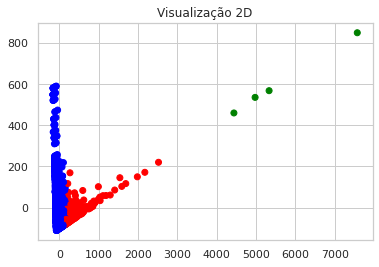

In [88]:
plot2d(X, colors, title='Visualização 2D - Redução de Escala')

## 1.3 Aplicando normalizações

Com o objetivo de reduzir o efeito da diferença de escala entre os atributos definidos, serão aplicadas técnicas de normalização que manterão os atributos com suas respectivas distribuições, mas normalizará a escala de todos os atributos, reduzindo a importância a priori encontrada no atributo anteriormente.

### Observação:

* Será que faz sentido realmente transformar todos os dados para a mesma escala? Alguns atributos podem ser mais importantes que outros. De certa forma, os clientes que gastam mais com a empresa, no fim das contas, são clientes mais relevantes e que não devem ser perdidos. Isso mostra que existe hierarquia entre os atributos e a importância de cada um deles, entretanto, para esta análise, isso será ignorado.

In [57]:
X = rfm[['Recency', 'Amount', 'Frequency']]
ss = sklearn.preprocessing.StandardScaler()
X_std = pd.DataFrame(ss.fit_transform(X), columns=['Recency', 'Amount', 'Frequency'])
X_std.head()

,Recency,Amount,Frequency
0,1.975600,-0.231001,-0.397606
1,-0.535025,0.293432,0.415662
2,-0.219002,-0.012316,-0.259082
3,-0.719372,-0.017146,-0.071405
4,1.843924,-0.190312,-0.321642


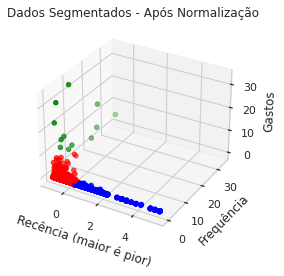

In [93]:
# Obtendo coordenadas
x = X_std['Recency']
y = X_std['Frequency']
z = X_std['Amount']

# Definindo novo modelo
colors = run_kmeans(X_std)

# Plot
plot3d(x, y, z, colors, zlabel='Gastos', title='Dados Segmentados - Após Normalização')